<a href="https://colab.research.google.com/github/ESQ0001/ImageMining/blob/master/Transfer_Learning_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,AveragePooling2D,Conv2D, MaxPooling2D, Flatten, Input, GlobalAveragePooling3D
from keras.applications import MobileNet, ResNet50, VGG16, InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Data Loading

In [0]:

import pickle
#these are the images in vector format
pickle_in = open("drive/My Drive/Colab Notebooks/pixels_desserts.pickle","rb")
pixels = pickle.load(pickle_in)


In [0]:
#these are the labelled images
pickle_off = open("drive/My Drive/Colab Notebooks/labels_desserts.pickle","rb")
labels = pickle.load(pickle_off)


In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [0]:
print(pixels.shape,labels.shape)

(16038, 150, 150, 3) (16038,)


churros (150, 150, 3)


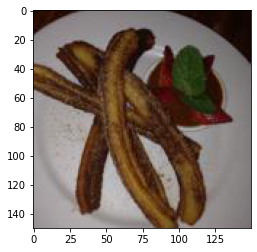

In [0]:
#manual checking of dataset
import matplotlib.pyplot as plt # conda install matplotlib -y
import numpy as np
n = -1 #replace this number to check yourself
plt.imshow(np.array(pixels[n]))
print(labels[n],pixels[n].shape)


In [0]:

labels[0].shape

()

In [0]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_vec = labelencoder.fit_transform(labels)
y_vec


array([1, 1, 7, ..., 5, 1, 9])

In [0]:
from keras.utils import to_categorical
y_categorical = to_categorical(y_vec)
y_categorical

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.model_selection import train_test_split
seed = 23

from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 

  

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(pixels, y_vec, test_size=0.20, random_state=seed)

print('Training set shape: {}'.format(X_train.shape))
print('Training set shape: {}'.format(y_train.shape))
print('Test set shape: {}'.format(X_test.shape))

Training set shape: (12830, 150, 150, 3)
Training set shape: (12830,)
Test set shape: (3208, 150, 150, 3)


In [0]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# ResNet50

In [0]:
def create_model_ResNet50():

  base_model=ResNet50(weights= None, include_top=True, classes=16,input_shape=(150,150,3)) #imports the vgg16 model and discards the last 1000 neuron layer.
  x=base_model.output
  
  #x=GlobalAveragePooling2D()(x)
  #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  #x=Dense(1024,activation='relu')(x) #dense layer 2
  #x=Dense(512,activation='relu')(x) #dense layer 3
  x= Dropout(0.4)(x)
  output=base_model.layers[-1].output
  #output = keras.layers.Flatten()(output)

  preds=Dense(16,activation='softmax')(x) #final layer with softmax activation
  model=Model(inputs=(base_model.input),outputs=output)
  return model
def train():
   model = create_model_ResNet50()
   opt=SGD(lr=0.001, momentum=0.9,nesterov=True)
   model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   print(model.summary())
   
   resNet50 = model.fit(x=X_train, y=y_train_one_hot, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test_one_hot), shuffle=True)
   test_eval = model.evaluate(X_test, y_test_one_hot, verbose=0)
   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])
   return resNet50

def load_trained_model(weights_path):
   model = create_model_ResNet50()
   model.load_weights(weights_path)
   return model

ResNet50


In [0]:
train()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________

In [0]:
import os
from google.colab.patches import cv2_imshow
from sklearn.datasets import make_blobs
def predict(pathToImg,model):
  
  #this is to check the dataset
  if(os.path.isfile(pathToImg)):
    fig = plt.figure(figsize=(20, 8))
    im = imread(pathToImg)
    Xnew = np.array(im)
    plt.imshow(Xnew)
    Xnew = np.expand_dims(im, axis =0)
    y_prob = model.predict(Xnew)[0]
    idxs = np.argsort(y_prob)[0]
    
    return idxs
  else:
    print("That file does not exist")
    return

In [0]:
#this is an example of transfer learning using ResNet50
def create_model_ResNet50():

  base_model=ResNet50(weights= 'imagenet', include_top=False, classes=16,input_shape=(150,150,3)) #imports the vgg16 model and discards the last 1000 neuron layer.
  x=base_model.output
  
  #x=GlobalAveragePooling2D()(x)
  #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  #x=Dense(1024,activation='relu')(x) #dense layer 2
  #x=Dense(512,activation='relu')(x) #dense layer 3
  x= Dropout(0.4)(x)
  output=base_model.layers[-1].output
  #output = keras.layers.Flatten()(output)

  preds=Dense(16,activation='softmax')(x) #final layer with softmax activation
  model=Model(inputs=(base_model.input),outputs=preds)
  return model
def train():
   model = create_model_ResNet50()
   opt=SGD(lr=0.001, momentum=0.9,nesterov=True)
   model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   print(model.summary())
   
   resNet50 = model.fit(x=X_train, y=y_train_one_hot, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test_one_hot), shuffle=True)
   test_eval = model.evaluate(X_test, y_test_one_hot, verbose=0)
   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])
   return model

def load_trained_model(weights_path):
   model = create_model_ResNet50()
   model.load_weights(weights_path)
   return model

In [0]:
resnet50_model = train()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

ValueError: ignored

# InceptionV3


In [0]:
#this is an example of transfer learning using ResNet50
def create_model_InceptionV3():
  model = InceptionV3(weights='imagenet',include_top=False)
  x = model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.65)(x)
  out = Dense(16,activation='softmax')(x)
  model_final = Model(input = model.input,outputs=out)
  print(model_final.summary())
  return model_final
def trainInceptionV3():
   model = create_model_InceptionV3()
   opt=SGD(lr=0.01, momentum=0.9,nesterov=True)
   model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   
   
   inceptionV3 = model.fit(x=X_train, y=y_train_one_hot, batch_size=32, epochs=25, verbose=1, validation_data=(X_test, y_test_one_hot), shuffle=True)
   test_eval = model.evaluate(X_test, y_test_one_hot, verbose=0)

   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])
   return model


In [0]:
mod_IV3 = trainInceptionV3()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_537 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_537 (BatchN (None, None, None, 3 96          conv2d_537[0][0]                 
__________________________________________________________________________________________________
activation_536 (Activation)     (None, None, None, 3 0           batch_normalization_537[0][0]    
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
inceptionV3 = trainInceptionV3()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, None, None, 3 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, None, None, 3 0           batch_normalization_283[0][0]    
____________________________________________________________________________________________

In [0]:
model_json = inceptionV3.to_json()
inceptionV3.save_weights("drive/My Drive/Colab Notebooks/modelWeights60.h5")
with open("drive/My Drive/Colab Notebooks/model_Inception60.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
#this is an example of transfer learning using InceptionV3 using preprocess_input
def create_model_InceptionV3_norm():
  model = InceptionV3(weights='imagenet',include_top=False)
  x = model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  #x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  out = Dense(16,activation='softmax')(x)
  model_final = Model(input = model.input,outputs=out)
  print(model_final.summary())
  return model_final
def trainInceptionV3_v2():
   model = create_model_InceptionV3_norm()
   opt=SGD(lr=0.001, momentum=0.9,nesterov=True)
   model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   
   
   inceptionV3 = model.fit(x=preprocess_input(X_train), y=y_train_one_hot, batch_size=64, epochs=15, verbose=1, validation_data=(preprocess_input(X_test), y_test_one_hot), shuffle=True)
   test_eval = model.evaluate(preprocess_input(X_test, y_test_one_hot, verbose=0)
   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])
   return inceptionV3

In [0]:
!nvidia-smi
trainInceptionV3_v2()


Mon May 11 16:31:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |   8739MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, None, None, 3 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, None, None, 3 0           batch_normalization_565[0][0]    
____________________________________________________________________________________________

In [0]:
#Yet another test- this time changing optimizer
#this is an example of transfer learning using InceptionV3 using preprocess_input
def create_model_InceptionV3_norm():
   model = InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))
   x = model.output
   x = GlobalAveragePooling2D()(x)
   x = Dense(1024, activation='relu')(x)
   #x = Dropout(0.5)(x)
   x = Dense(512, activation='relu')(x)
   x = Dropout(0.5)(x)
   out = Dense(16,activation='softmax')(x)
   model_final = Model(input = model.input,outputs=out)
   print(model_final.summary())
   opt=Adam(learning_rate=0.01)
   model_final.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   
   
   inceptionV3 = model_final.fit(x=preprocess_input(X_train), y=y_train_one_hot, batch_size=64, epochs=15, verbose=1, validation_data=(preprocess_input(X_test), y_test_one_hot), shuffle=True)
   test_eval = model_final.evaluate(preprocess_input(X_test), y_test_one_hot, verbose=0)
   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])
   inceptionV3.plot(hist.history['accuracy'])
   inceptionV3.plot(hist.history['val_accuracy'])
   inceptionV3.title('Model accuracy')
   inceptionV3.ylabel('Accuracy')
   inceptionV3.xlabel('Epoch')
   inceptionV3.legend(['Train', 'Val'], loc='upper left')
   inceptionV3.show()
#Visualize the models loss
   inceptionV3.plot(hist.history['loss'])
   inceptionV3.plot(hist.history['val_loss'])
   inceptionV3.title('Model loss')
   inceptionV3.ylabel('Loss')
   inceptionV3.xlabel('Epoch')
   inceptionV3.legend(['Train', 'Val'], loc='upper right')
   inceptionV3.show()
   return model_final

In [0]:
modelInceptionV3 = create_model_InceptionV3_norm()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 74, 74, 32)   96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 74, 74, 32)   0           batch_normalization_377[0][0]    
____________________________________________________________________________________________

KeyboardInterrupt: ignored

# VGG16


In [0]:
from keras.applications.vgg16 import preprocess_input
def create_model_VGG16():  
  prepared_images = preprocess_input(pixels)
  new_input = Input(shape=(150, 150, 3))
  modelVGG16 = VGG16(weights=None, input_tensor=new_input, classes=16)
  return modelVGG16

def trainVGG16():
   model = create_model_VGG16()
   opt=Adam(learning_rate=0.01)
   model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
   vgg16 = model.fit(x=X_train, y=y_train_one_hot, batch_size=64, epochs=15, verbose=1, validation_data=(X_test, y_test_one_hot), shuffle=True)
   test_eval = model.evaluate(X_test, y_test_one_hot, verbose=0)
   print('Test loss:', test_eval[0])
   print('Test accuracy:', test_eval[1])  
#Visualize the models accuracy
   vgg16.plot(hist.history['accuracy'])
   vgg16.plot(hist.history['val_accuracy'])
   vgg16.title('Model accuracy')
   vgg16.ylabel('Accuracy')
   vgg16.xlabel('Epoch')
   vgg16.legend(['Train', 'Val'], loc='upper left')
   vgg16.show()
#Visualize the models loss
   vgg16.plot(hist.history['loss'])
   vgg16.plot(hist.history['val_loss'])
   vgg16.title('Model loss')
   vgg16.ylabel('Loss')
   vgg16.xlabel('Epoch')
   vgg16.legend(['Train', 'Val'], loc='upper right')
   vgg16.show()
   return vgg16

In [0]:
trainVGG16()

In [0]:
from keras.preprocessing import image
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np

batch_size = 40
num_classes = 16

#base_model = resnet50.ResNet50
#base_model = inception_v3.InceptionV3
base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

x_train = resnet50.preprocess_input(X_train)
x_test = resnet50.preprocess_input(X_test)
print(model.evaluate(x_train, y_train, batch_size=batch_size, verbose=0))
model.fit(x=x_train, y=y_train_one_hot, batch_size=64, epochs=15, verbose=1, validation_data=(x_test, y_test_one_hot), shuffle=True)

[9.864037818492434, 0.07147310674190521]


ValueError: ignored

ValueError: ignored

# InceptionResNetV2

# In conclusion and some tests

In [0]:
#prediction function
import os
from google.colab.patches import cv2_imshow
from sklearn.datasets import make_blobs
from skimage.io import imread
def predict(pathToImg,model):
  
  #this is to check the dataset
  if(os.path.isfile(pathToImg)):
    fig = plt.figure(figsize=(20, 8))
    im = imread(pathToImg)
    Xnew = np.array(im)
    plt.imshow(Xnew)
    Xnew = np.expand_dims(im, axis =3)
    y_prob = model.predict(Xnew)[0]
    idxs = np.argsort(y_prob)[0]
    foods = np.unique(labels)

    
    return foods[idxs]
  else:
    print("That file does not exist")
    return

In [0]:
a = np.expand_dims(pixels[1],axis=0)

In [0]:
inceptionV3.predict(a)

array([[4.1859192e-03, 9.7104567e-01, 1.5054493e-03, 3.0200087e-04,
        2.8403574e-03, 1.9703903e-03, 4.6723624e-04, 2.3435540e-03,
        6.0810329e-04, 1.5018642e-03, 3.1735710e-04, 2.1034027e-03,
        8.9550801e-03, 1.1647131e-03, 3.7130341e-04, 3.1774200e-04]],
      dtype=float32)

In [0]:
labels[1]


'baklava'

TypeError: ignored

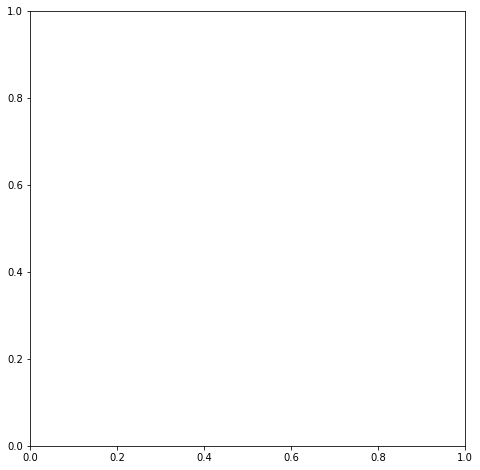

In [0]:
predict(inceptionV3,pixel)
